Linguist 278: Programming for Linguists<br />
Stanford Linguistics, Fall 2019<br />
Christopher Potts

# Assignment 8: Language dataset hackathon

Distributed 2019-11-18<br />
Due 2019-12-02 (but my intention is that you will be able to turn it in after class on Nov 20)

## Contents

1. [Overview](#Overview)
0. [Set-up](#Set-up)
0. [Datasets/text sources used in this project](#Datasets/text-sources-used-in-this-project)
  1. [Sentiment dataset](#Sentiment-dataset)
  0. [Synsets from WordNet](#Synsets-from-WordNet)
  0. [Novels from Project Gutenberg](#Novels-from-Project-Gutenberg)
  0. [Sense-tagged sentences from SemCor](#Sense-tagged-sentences-from-SemCor)
0. [Project main code by module](#Project-main-code-by-module)
  1. [Word tokenizer](#Word-tokenizer)
  0. [Word sense and synonyms by context](#Word-sense-and-synonyms-by-context)
  0. [Visualization of words vs their most frequent alternatives](#Visualization-of-words-vs-their-most-frequent-alternatives)

## Overview

For every word a writer chooses to use, there may be other alternative words they could have chosen to describe the very same concept. While these alternative words may have the same conceptual meanings, they could have different sentiments ratings for semantic dimensions such as valence, arousal, and dominance.

This projects allows a user to visually see the valence, arousal, and dominance ratings for words a writer chooses to use, compared to the ratings of these words' most frequent alternatives, across time within a paragraph. It also allows a user to see comparisons at the paragraph level across texts through rating means. The project also allows the user to access information about words with maximum semantic dimension distance from alternatives at both the word and paragraph levels 

Bare semantic dimension ratings can give an idea of where on the spectrum of sentiment a word lies. Comparing the words a writer chooses to the words' alternatives could add another dimension of understanding to a writer's stance by helping identify where the word choice positions itself in relation to other words that could refer to the same concept.

In order to identify what alternatives should be looked at, I also implemented a rough way to try to determine word sense based on context words

## Set-up

In [1]:
%matplotlib inline
import glob
import os
import pandas as pd
import numpy as np

## Datasets/text sources used in this project

Below are the datasets and text sources used in this project.

Download the data distribution:
    
http://web.stanford.edu/class/linguist278/data/hackathon.zip

and unzip it in the same directory as this notebook. (If you want to put it somewhere else, just be sure to change `data_home` in the next cell.)    

In [2]:
data_home = "hackathon"

### Sentiment dataset

The dataset [Norms of valence, arousal, and dominance for 13,915 English lemmas](https://www.humanities.mcmaster.ca/~vickup/Warriner-etal-BRM-2013.pdf) (Amy Beth Warriner, Victor Kuperman, and Marc Brysbaert, _Behavior Research Methods_, 2013) contains a lot of sentiment information about +13K words. The following code reads in the full dataset and then restricts to just the mean ratings for the three core semantic dimensions:

0. `Word`: The word (str)
1. `Valence` (positive/negative)
2. `Arousal` (intensity)
3. `Dominance`

In [3]:
sentiment_df_filename = os.path.join(data_home, "Warriner_et_al emot ratings.csv")

### Synsets from WordNet

WordNet contains sets of words that have similar meanings called synsets. For a given word, you can access the synsets it is a part of, thus getting a set of the word's synonyms for each of its word senses. 

Princeton University "About WordNet." [WordNet](https://wordnet.princeton.edu/). Princeton University. 2010. 

### Novels from Project Gutenberg

The Gutenberg metadata has been removed from these files, and the first line gives the title, author, and publication year in a systematic pattern. 

The text from these novels can be accessed at [paragraph](#Project-Gutenberg-iterator-(by-paragraph)), [sentence](#Sentence-tokenizing-using-NLTK), and [word](#Word-tokenizer-from-assignment-2) levels.

In [4]:
gutenberg_home = os.path.join(data_home, "gutenberg")

In [5]:
gutenberg_filenames = glob.glob(os.path.join(gutenberg_home, "*.txt"))

### Sense-tagged sentences from SemCor

SemCor is a subset of the Brown corpus, tagged for WordNet sense and part-of-speech. 

[SourceInfo](https://www.kaggle.com/nltkdata/semcor-corpus)

# Project main code by module

## Word tokenizer

In [6]:
import mywordtokenizer

In [7]:
mywordtokenizer.simple("Before you eat the banana, peel it.")

['before', 'you', 'eat', 'the', 'banana', 'peel', 'it']

## Word sense and synonyms by context

A given word is often part often multiple synsets that correspond to different senses of the word. When we are comparing a word to its most frequent alternative in a particular context, we want to only compare it to synonyms for its word sense in this particular context. 

But if a word isn't marked differently based on what word sense it's capturing, how can we tell what alternatives to look at? For one, we can manually mark the texts we're looking at to encode this data, or only use corpora that are marked for word sense (e.g. SemCor). Alternatively, we could use these kinds of corpora to find most common contextual clues for different words, and use this to inform a categorization of a word based on context. This will not be as accurate, but will allow for a far larger range of applicability.

The wordSenseByContext python module aims to create resources for identifying in what sense a word is being used. 

In particular, we are importing SenseContextWordDict, which is a class that essential represents a dictionary from word sense to context words. While currently there is no variety in the dictionaries created. In future versions, this could be updated to accomodate making SenseContextWordDicts from different annotated corpora.

In [8]:
from wordSenseByContext import SenseContextWordDict

In [9]:
from nltk.corpus import wordnet as wn

### Dictionary from synsets to context words to frequencies
Here, we're creating a file that maps a given synset to a map from all the other words (bare forms not word sense annotated) that occurred in a paragraph with a word of that synset to the number of times each of these words occurred in this vicinity.

In [10]:
myDict = SenseContextWordDict()

In [11]:
myDict.dictionary[wn.synsets("news")[3]]

defaultdict(int,
            {'likewise': 1,
             '.total.': 34,
             '.totalNoStops.': 32,
             '': 13,
             'equally': 1,
             'fascinating': 1,
             'the': 1,
             'that': 1,
             'unlikely': 1,
             'synonym': 1,
             'pratakku': 1,
             'sweathruna': 1,
             'tongue': 1,
             'twister': 1,
             'nnuolapertar-it-vuh-karti-biri-pitknoumen': 1,
             'originate': 1,
             'village': 1,
             'location': 1,
             'use': 1,
             'express': 1,
             'sentiment': 1,
             'concern': 1,
             'british': 1,
             'imperialism': 1})

### Finding most likely synset for word in a context sentence
We can input a word and the context it occurs in in order to get its most likely synset for that word sense.

In [12]:
mostLikelySynset = myDict.getMostLikelySynset("report", ["they", "report", "on", "multiple", "big", "news", "stories"])

In [13]:
mostLikelySynset.examples()

["Snow reported on China in the 1950's",
 'The cub reporter covered New York City']

### Finding alternatives for a word in a context sentence
We can input a word and the context it occurs in in order to get its alternatives

In [14]:
alternatives = myDict.listAlternatives("reports", ["news","of", "the", "report", "spread", "around", "the", "school"])
alternatives

{'account', 'news_report', 'report', 'story', 'write_up'}

### Finding most frequent alternative for a word in a context sentence
We can input a word and the context it occurs in in order to get its most frequent alternative

Here we can see that report is the most frequently used word for this sense:

In [15]:
mostFrequentAlternative = myDict.mostFrequentAlternative("reports", ["news","of", "the", "report", "spread", "around", "the", "school"])
mostFrequentAlternative

'report'

## Visualization of words vs their most frequent alternatives

In [16]:
import wordAltSentimentVisualization as wasv

### Gutenberg iterator

Allows you to iterate through input Gutenberg files by paragraph

In [17]:
wasv.gutenberg_iterator

<function wordAltSentimentVisualization.gutenberg_iterator(filename)>

In [18]:
file_iterator = wasv.gutenberg_iterator(gutenberg_filenames[6])
next(file_iterator)
next(file_iterator)
paragraphstring = next(file_iterator)

In [19]:
paragraphstring

"One thing was certain, that the WHITE kitten had had nothing to do with\nit:--it was the black kitten's fault entirely. For the white kitten had\nbeen having its face washed by the old cat for the last quarter of\nan hour (and bearing it pretty well, considering); so you see that it\nCOULDN'T have had any hand in the mischief."

### Get sentiment dataframe

sentiment_df below is a dataframe that ultimately allows from access to the average valence, arousal, and dominance values of all of the words in this dataset.

In [20]:
sentiment_df = wasv.createSentimentDF(sentiment_df_filename)

In [21]:
sentiment_df.head()

,Valence,Arousal,Dominance
Word,,,
aardvark,6.26,2.41,4.27
abalone,5.30,2.65,4.95
abandon,2.84,3.73,3.32
abandonment,2.63,4.95,2.64
abbey,5.85,2.20,5.00


### Looking at words and their alternatives across a paragraph

We can look at words and their most frequent alternatives individually at the word-level across a paragraph. 

Let's take a the paragraph we retrieved from one of our gutenberg files for example:

In [22]:
paragraphstring

"One thing was certain, that the WHITE kitten had had nothing to do with\nit:--it was the black kitten's fault entirely. For the white kitten had\nbeen having its face washed by the old cat for the last quarter of\nan hour (and bearing it pretty well, considering); so you see that it\nCOULDN'T have had any hand in the mischief."

Since our datasets for sentiment and frequency values are not all encompassing, it is expected that we will not be able to have all of these values for every word.

We can leave words that don't have every single one of these values in our tables, so that we can more accurately visualize the time distribution, as shown in the comparison_table function. Or, we can prune these words out as shown in the comparison_table_available_values function.

##### All words

In [23]:
table = wasv.comparison_table(paragraphstring, myDict, sentiment_df)

In [24]:
table.head()

,Word,WordA,WordV,WordD,MostFreqAlt,AltA,AltV,AltD
0,one,2.67,6.09,5.56,NaN,NaN,NaN,NaN
1,thing,3.43,5.55,5.41,NaN,NaN,NaN,NaN
2,was,NaN,NaN,NaN,be,3.43,6.18,5.50
3,certain,3.00,6.11,6.78,sure,3.48,6.64,6.82
4,that,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Distribution over time is more evident, but especially with line plot, it can be difficult to see all points.

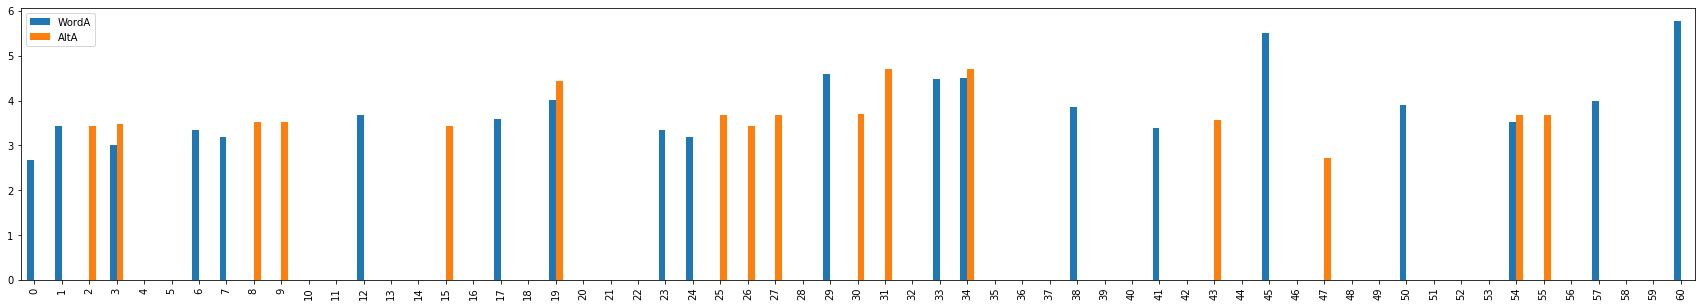

In [25]:
table[['WordA','AltA']].plot.bar(figsize=(30,5))

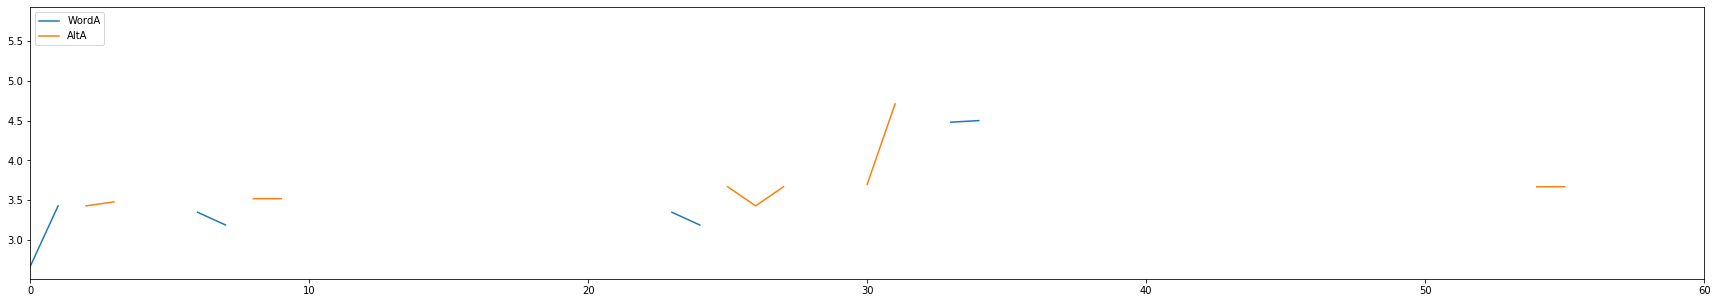

In [26]:
table[['WordA','AltA']].plot.line(figsize=(30,5))

##### Only words without unknown ratings

In [27]:
prunedTable = wasv.comparison_table_available_values(table)

In [28]:
prunedTable.head()

,Word,WordA,WordV,WordD,MostFreqAlt,AltA,AltV,AltD
3,certain,3.00,6.11,6.78,sure,3.48,6.64,6.82
19,fault,4.02,3.53,4.02,error,4.43,3.36,4.18
34,cat,4.50,6.95,5.48,guy,4.71,6.55,5.12
54,have,3.52,5.86,5.72,get,3.67,6.09,5.65


We can see all points more clearly in line plot, but it can be misleading because you can't always tell where there are missing data points.

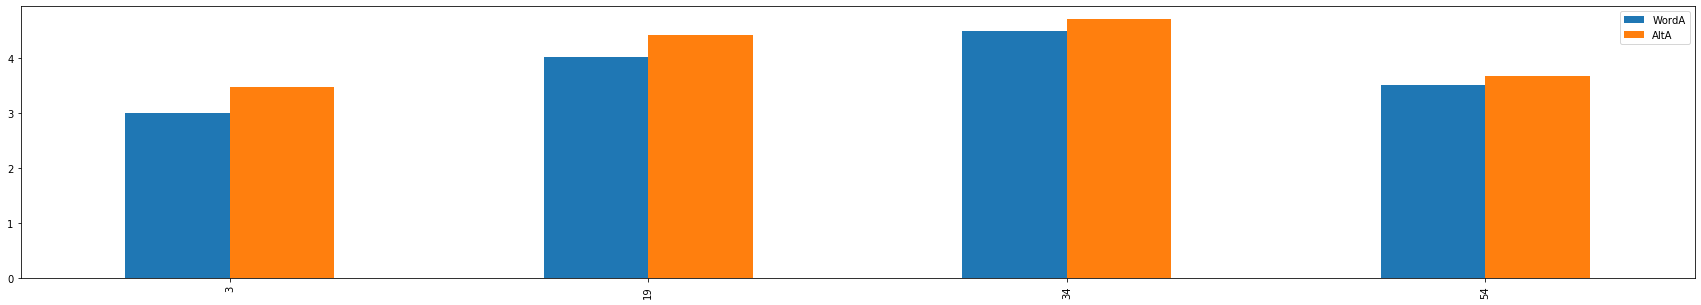

In [29]:
prunedTable[['WordA','AltA']].plot.bar(figsize=(30,5))

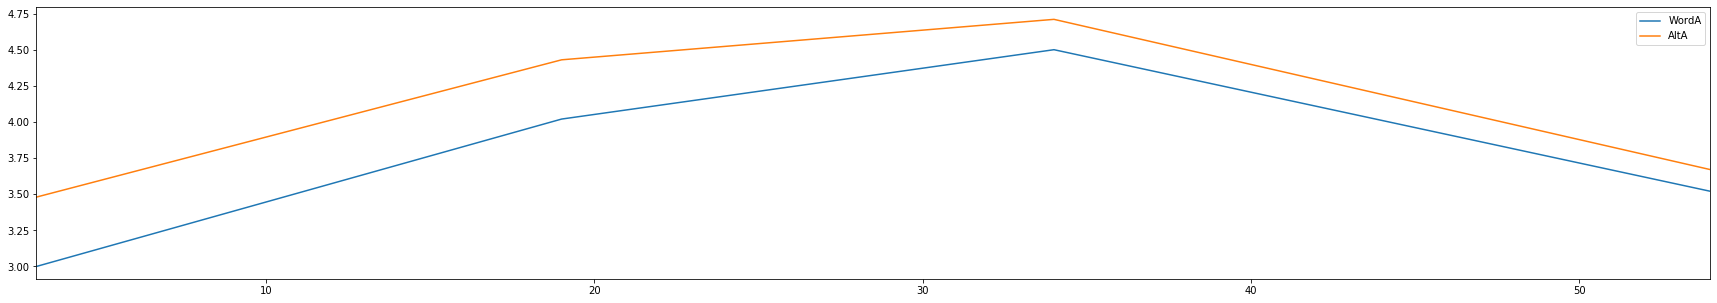

In [30]:
prunedTable[['WordA','AltA']].plot.line(figsize=(30,5))

#### Word with biggest difference from alternative for each of the semantic dimensions

We can find the word that has the greatest difference in arousal/valence/dominance rating from its most frequent alternative.

In [31]:
wasv.biggest_differences_words(prunedTable)['Arousal']

Word           certain
WordA                3
WordV             6.11
WordD             6.78
MostFreqAlt       sure
AltA              3.48
AltV              6.64
AltD              6.82
absADiff          0.48
absVDiff          0.53
absDDiff          0.04
Name: 3, dtype: object

### Looking at paragraph averages for words and their alternatives across a file

We can also look at paragraphs' average semantic dimension ratings for words and their most frequent alternatives at a broader level across a whole file. 

Let's look at the first 21 paragraphs of one of our gutenberg files for example:

In [32]:
firstTwentyTrend = wasv.paragraphAverages(gutenberg_filenames[6], myDict, sentiment_df, 21)

Average arousal ratings for words and their most frequent alternatives over time.

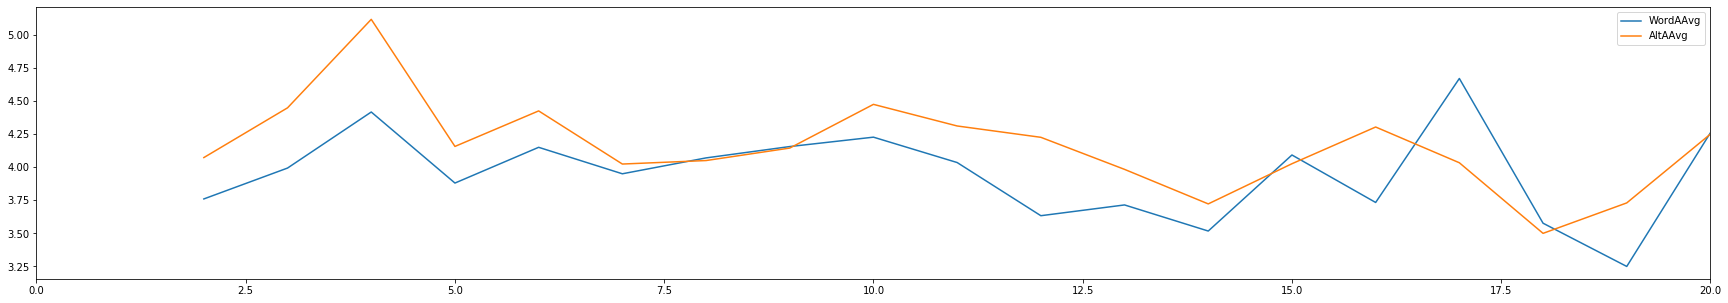

In [33]:
firstTwentyTrend[['WordAAvg','AltAAvg']].plot.line(figsize=(30,5))

Average valence ratings for words and their most frequent alternatives over time.

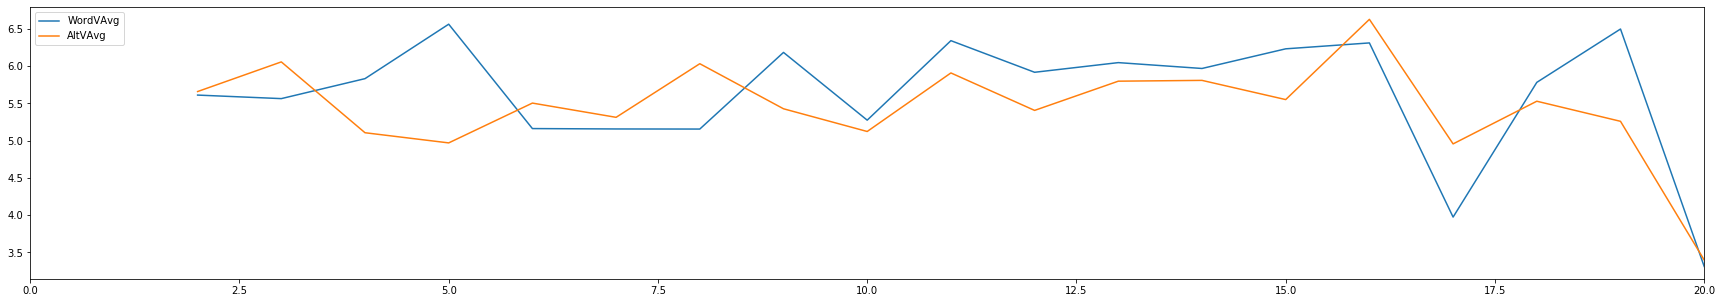

In [34]:
firstTwentyTrend[['WordVAvg','AltVAvg']].plot.line(figsize=(30,5))

Average dominance ratings for words and their most frequent alternatives over time.

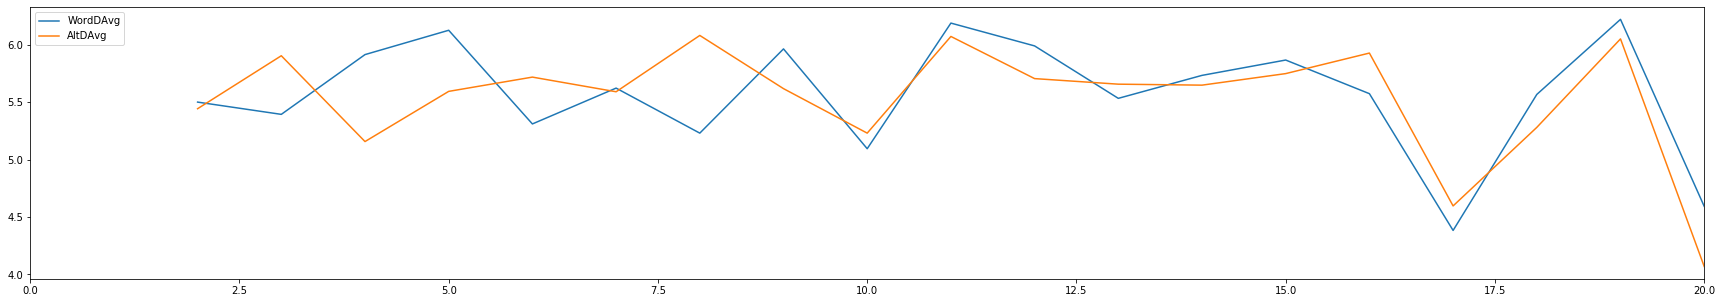

In [35]:
firstTwentyTrend[['WordDAvg','AltDAvg']].plot.line(figsize=(30,5))

#### Paragraph with biggest difference between words and alternatives for each of the semantic dimensions

We can find the paragraph that has the greatest difference in average arousal/valence/dominance rating between words and from their most frequent alternatives.

Paragraph 20 has the greatest difference in Valence as shown below

In [36]:
wasv.biggest_differences_paragraphs(firstTwentyTrend)['Valence']

WordAAvg       3.880000
WordVAvg       6.565000
WordDAvg       6.125000
AltAAvg        4.156667
AltVAvg        4.970000
AltDAvg        5.593333
absAAvgDiff    0.276667
absVAvgDiff    1.595000
absDAvgDiff    0.531667
Name: 5, dtype: float64